*This notebook was created by Sergey Tomin (sergey.tomin@desy.de). Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). May 2020.*

### Appendix: some useful OCELOT functions

This notebook was created to show some small functions that may be useful for accelerator physicists.
### Contents
1. [Aperture](#aperture)
2. [RK tracking](#rk)

In [1]:
# import modules
from ocelot import *
from ocelot.gui.accelerator import *
import copy
import pandas as pd
import seaborn as sbn
import time
import matplotlib.pyplot as plt

initializing ocelot...


<a id='aperture'></a>
### Aperture
Suppose you have a simple (and imposible) missaligned dump beam line. 
And you want to know the best corrector setting to get 100% transmission. 

We are goring to explor the transmission in horizontal only. 

#### Lattice 

In [2]:
d = Drift(l=1)

# horizontal correctors
c1 = Hcor()
c2 = Hcor()

# Sextupoles
sf = Sextupole(l=0.2, k2=3000)
sf.dx, sf.dy = 1e-3, -1e-3

sd = Sextupole(l=0.2, k2=-3000)
sd.dx, sd.dy = 1e-3, -1e-3


# Quadrupoles with transversal offsets
qf = Quadrupole(l=0.2, k1=1, k2=20)
qf.dx, qf.dy = 1e-3, -1e-3

qd = Quadrupole(l=0.2, k1=-1, k2=-20)
qd.dx, qd.dy = -1e-3, 1e-3

# Collimators
ap1 = Aperture(xmax=5e-3, dx=-1e-3)
ap2 = Aperture(xmax=5e-3, dx=1e-3)
# BPMs
m1 = Monitor()
m2 = Monitor()

cell = (d, c1, d, sf, d, qf, d, ap1, d, m1, d, c2, d, sd, d, qd, d, ap2, d, m2, d,)

lat = MagneticLattice(cell, method=MethodTM({"global": SecondTM}))

Create ParticleArray and Navigator objects

In [3]:
p_array_init = generate_parray(sigma_x=1e-3, sigma_px=5e-5, sigma_y=1e-3, sigma_py=5e-5, 
                               nparticles=20000, charge=1e-09, energy=1.)

correctors = [c1, c2]



#### function to calculate transmission through the lattice

In [4]:
def transmission(lat, navi, correctors, kicks):
    for i, kick in enumerate(kicks):
        correctors[i].angle = kick
    
    lat.update_transfer_maps()
    
    # reset position of the Navigator 
    navi.reset_position()
    
    p_array = copy.deepcopy(p_array_init)
    tws_tack, p_array = track(lat, p_array, navi, calc_tws=False, print_progress=False)
    trans = p_array.n / p_array_init.n
    return trans


def scan(cor1_range, cor2_range):
    trans_response = np.zeros((len(cor2_range), len(cor1_range)))

    for i, a2 in enumerate(A2):
        print(f"{i} of {len(A2)}", end="\r")
        for j, a1 in enumerate(A1):
            kicks = [a1, a2]
            trans_response[i, j] = transmission(lat, navi, correctors, kicks)
    
    return trans_response

### Scan with two correctors. Apertures are NOT activated. 
Here we expect 100% transmission for any corrector settings.

 exec n_tracks=612:  59.041210889816284 s


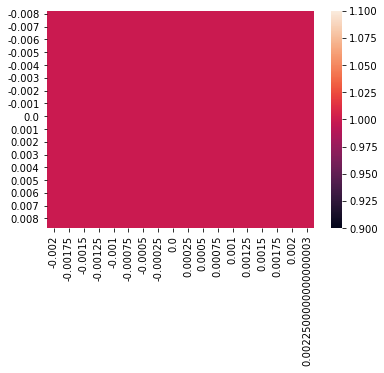

In [5]:
navi = Navigator(lat)

A1 = np.arange(-2, 2.5, 0.25)*1e-3
A2 = np.arange(-8, 9., 0.5)*1e-3

start = time.time()

trans_response = scan(A1, A2)

print(f" exec n_tracks={len(A2) * len(A1)}:  {time.time() - start} s")
df = pd.DataFrame(trans_response, index=A2, columns=A1)
sbn.heatmap(df)
plt.show()

### Scan with two correctors. Apertures are activated. 

 exec n_tracks=612:  95.46063995361328 s


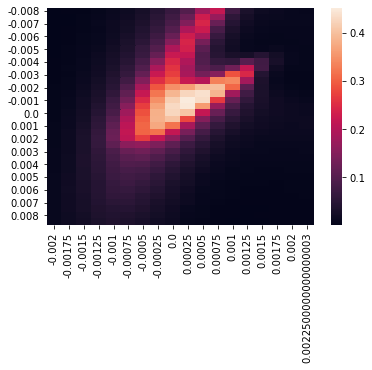

In [6]:
navi = Navigator(lat)

# activate apertures
navi.activate_apertures()

# activate apertures starting from element "start" up to element "stop"
# navi.activate_apertures(start=None, stop=m1)

start = time.time()

trans_response = scan(A1, A2)

print(f" exec n_tracks={len(A2) * len(A1)}:  {time.time() - start} s")
df = pd.DataFrame(trans_response, index=A2, columns=A1)
sbn.heatmap(df)
plt.show()

## Losses along accelerator lattice

New feature which is available currently in dev branch.

```ParticleArray``` has ```lost_particle_recorder atribute``` (```LostParticleRecorder```) has list of  s_positions along accelerator and number of particles which were lost at that point

```p_array.lost_particle_recorder.lp_to_pos_hist = [(s1, n_lost_particles), (s2, n_lost_particlse), ..., (sn, n_lost_particlse)]```

transmission:  0.4268


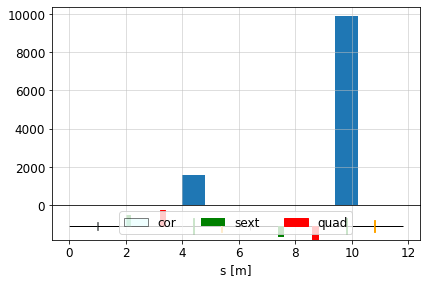

In [7]:
navi = Navigator(lat)

# activate apertures
navi.activate_apertures()

c1.angle = 0
c2.angle = 0

lat.update_transfer_maps()
    
# reset position of the Navigator 
navi.reset_position()
    
p_array = copy.deepcopy(p_array_init)
tws_tack, p_array = track(lat, p_array, navi, calc_tws=False, print_progress=False)
trans = p_array.n / p_array_init.n
print("transmission: ", trans)

s = [p[0] for p in p_array.lost_particle_recorder.lp_to_pos_hist]
nlost = [p[1] for p in p_array.lost_particle_recorder.lp_to_pos_hist]

fig, ax_xy = plot_API(lat, legend=True, fig_name=10)
ax_xy.bar(s, nlost)
plt.show()


<a id='rk'></a>
## Tracking the electron beam with Runge-Kutta integrator in magnetic fields

In OCELOT, there is a possibility to track the beam in the arbitrary defined 3D magnetic fields. 

You need two components to do this: 
1. define the 3D magnetic fields 
2. MethodTM, the class which creates Transfer Maps, should know that you want to apply RK integrator to an element


### define 3D Magnetic fields. 

In [8]:
lperiod = 0.01 # [m] undulator period 
nperiods = 50  # number of periods
Kx = 2         # undulator deflection parameter


def und_field_3D(x, y, z, lperiod, Kx):
    kx = 0.
    kz = 2 * pi / lperiod
    ky = np.sqrt(kz * kz + kx * kx)
    c = speed_of_light
    m0 = m_e_eV
    B0 = Kx * m0 * kz / c
    k1 = -B0 * kx / ky
    k2 = -B0 * kz / ky

    kx_x = kx * x
    ky_y = ky * y
    kz_z = kz * z

    cosz = np.cos(kz_z)

    cosx = np.cos(kx_x)
    sinhy = np.sinh(ky_y)
    Bx = k1 * np.sin(kx_x) * sinhy * cosz 
    By = B0 * cosx * np.cosh(ky_y) * cosz
    Bz = k2 * cosx * sinhy * np.sin(kz_z)
    return (Bx, By, Bz)


und = Undulator(lperiod=lperiod, nperiods=nperiods, Kx=Kx, eid="und")
und.mag_field = lambda x, y, z: und_field_3D(x, y, z, lperiod=lperiod, Kx=Kx)

# define number of points along z-axis, by default npoints = 200
und.npoints = 500 

### Create MagneticLattice and MethodTM

In [9]:
from ocelot.cpbd.optics import RungeKuttaTM
d = Drift(l=0.5)
qf = Quadrupole(l=0.2, k1=1.2)
qd = Quadrupole(l=0.2, k1=-1.2)

method = MethodTM()
# let the MethodTM to know
method.params[Undulator] = RungeKuttaTM


lat = MagneticLattice((d, qf, d, qd, d, und, d, qf, d, qd, d), method=method)

### Tracking through the lattice WITH RK integrator

In [10]:
p_array = copy.deepcopy(p_array_init)

navi = Navigator(lat)

tws_track, _ = track(lat, p_array, navi)



z = 4.3 / 4.300000000000001 : applied: 001 : applied: 

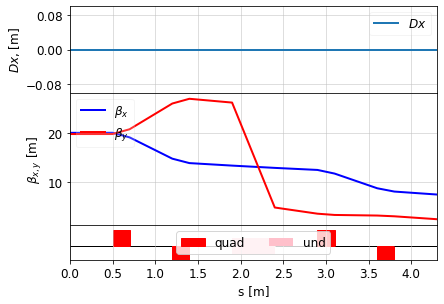

In [11]:
plot_opt_func(lat, tws_track)
plt.show()

### Tracking through the lattice WITHOUT RK integrator 

z = 4.3 / 4.300000000000001 : applied: 001 : applied: 

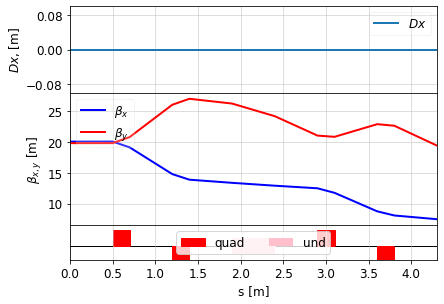

In [12]:
d = Drift(l=0.5)
qf = Quadrupole(l=0.2, k1=1.2)
qd = Quadrupole(l=0.2, k1=-1.2)

method = MethodTM()

lat = MagneticLattice((d, qf, d, qd, d, und, d, qf, d, qd, d), method=method)
p_array = copy.deepcopy(p_array_init)

navi = Navigator(lat)

tws_track, _ = track(lat, p_array, navi)

plot_opt_func(lat, tws_track)
plt.show()

## To be continued ... 